Table of Contents
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Analysis
## Data Exploration

In [2]:
# Math stuff
import numpy as np
# For handling dataset
import pandas as pd
# For plotting
import matplotlib.pyplot as plt
# For plotting
import seaborn as sns
sns.set_style("white")
# For plotting
import plotly.plotly as py
import plotly.graph_objs as go
# For list the feature importance
from sklearn.ensemble import RandomForestClassifier
# For feature transformation
from sklearn.preprocessing import FunctionTransformer
# helping to remove outliers
from scipy.stats import iqr
# For undersampling
from imblearn.under_sampling import RandomUnderSampler
# metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

Let's load the data in order to do some analysis

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

As we can see, the dataset contains 31 features which each one is a numerical data. <br />
The feature Class is a categorical data labeling if the transaction is legit or fraud. <br />
One of the characteristics is the highly imbalance between legit and fraud transaction.

So, let's plot and see it.

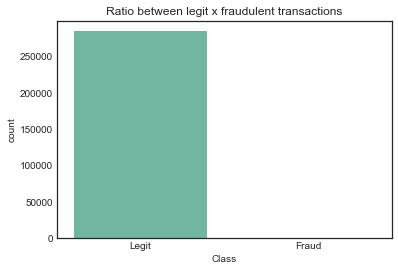

In [6]:
fig = plt.figure()

sns.countplot(df.Class, palette="Set2")
plt.xticks([0,1], ['Legit', 'Fraud'])
plt.title('Ratio between legit x fraudulent transactions')

# fig.savefig('imgs/fig2 ratio-legitxfraud.png')

plt.show()

Now, let's summarize the whole data...

In [7]:
df.describe().transpose()[::-1]

,count,mean,std,min,25%,50%,75%,max
Class,284807.0,1.727486e-03,0.041527,0.000000,0.000000,0.000000,0.000000,1.000000
Amount,284807.0,8.834962e+01,250.120109,0.000000,5.600000,22.000000,77.165000,25691.160000
V28,284807.0,-1.220404e-16,0.330083,-15.430084,-0.052960,0.011244,0.078280,33.847808
V27,284807.0,-3.666453e-16,0.403632,-22.565679,-0.070840,0.001342,0.091045,31.612198
V26,284807.0,1.687098e-15,0.482227,-2.604551,-0.326984,-0.052139,0.240952,3.517346
V25,284807.0,5.340915e-16,0.521278,-10.295397,-0.317145,0.016594,0.350716,7.519589
V24,284807.0,4.471968e-15,0.605647,-2.836627,-0.354586,0.040976,0.439527,4.584549
V23,284807.0,2.578648e-16,0.624460,-44.807735,-0.161846,-0.011193,0.147642,22.528412
V22,284807.0,-3.444850e-16,0.725702,-10.933144,-0.542350,0.006782,0.528554,10.503090
V21,284807.0,1.656562e-16,0.734524,-34.830382,-0.228395,-0.029450,0.186377,27.202839


This summary is hard to see something. But, here some things to notice:
* The mean of the feature V1 to V28 are next to zero.
* The difference between the max value and the 75% quantile of the feature Amount is huge.


Let's plot the distributions of the features Vs.

In [8]:
feats = df.columns[1:-2]
print feats

Index([u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9', u'V10',
       u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18', u'V19',
       u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27', u'V28'],
      dtype='object')


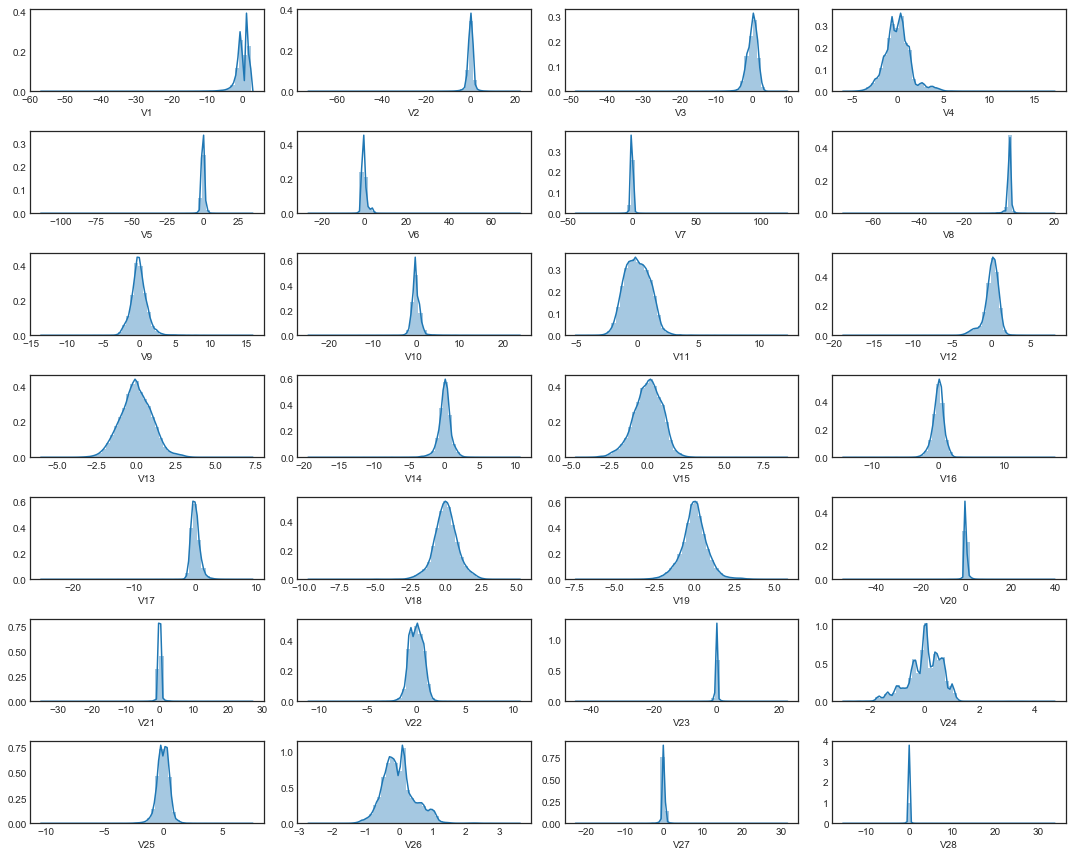

In [9]:
fig = plt.figure(figsize=(15, 12))

for idx, feat in enumerate(feats):
    plt.subplot(7, 4, idx+1) 
    sns.distplot(df[feat])

plt.tight_layout()
plt.show()

# fig.savefig('imgs/Vs distplot.png')

The plot above is clear to see that the mean is around zero. So, it reflects the summary. <br />
Another thing to notice is that by the extension of the x-axis, show us that all them have outliers. <br />

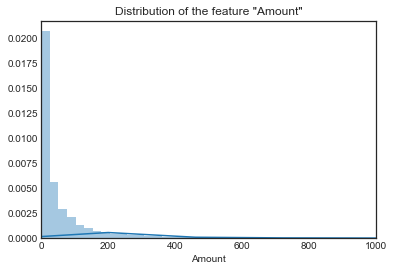

In [10]:
fig = plt.figure()

plt.title('Distribution of the feature "Amount"')
sns.distplot(df.Amount, bins=1000)
plt.xlim(0, 1000)
plt.show()

# fig.savefig('imgs/fig3.png')

The feature amount is positively-skewed. So, it will need a transformation.

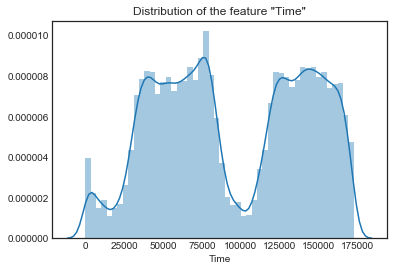

In [11]:
fig = plt.figure()

sns.distplot(df.Time)
plt.title('Distribution of the feature "Time"')
plt.show()

# fig.savefig('imgs/fig4.png')

This feature presents somehow a bimodal distribution. Since, the dataset contains transactions of two days, this could be a reflection of it. <br /><br />

## Data Preprocessing
### Feature Selection
Now that we had an overview about the dataset, it might be a good idea to choose the features that most explain the relation between legit and fraud.

I'll be doing this through Random Forest and list the features by importance. <br />
Since Decision Trees aren't sensitive to outliers, it should be fine to just run it.

In [12]:
# Since I won't be working with recurrent model, I'll be ignoring this feature
del df['Time']

In [13]:
# making a copy of the data to work
X = df.iloc[:,:].copy()

In [14]:
np.bincount(X.Class)

array([284315,    492], dtype=int64)

In [15]:
# separating the predictors and the labels
X, y = X.iloc[:,:-1], X.iloc[:,-1]

In [16]:
rus = RandomUnderSampler(ratio={0:246*20, 1:246}, random_state=0, return_indices=True)

In [17]:
X_resampled, y_resampled, idx = rus.fit_sample(X, y)

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
parameter_candidates = [
  {'n_estimators': [5, 10, 15, 20], 'criterion': ['gini', 'entropy'], \
   'random_state':[0], 'class_weight':['balanced', None], 'bootstrap':[True], \
   'oob_score':[True, False], 'min_samples_split':[2, 4, 6, 8], 'min_samples_leaf':[1, 2, 4, 6, 8]},

  {'n_estimators': [5, 10, 15, 20], 'criterion': ['gini', 'entropy'], \
   'random_state':[0], 'class_weight':['balanced', None], 'bootstrap':[False], \
   'min_samples_split':[2, 4, 6, 8], 'min_samples_leaf':[1, 2, 4, 6, 8]}
]

In [20]:
from sklearn.metrics import make_scorer

In [21]:
scoring = {'AUC':make_scorer(average_precision_score)}

In [22]:
# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameter_candidates, n_jobs=-1, scoring=make_scorer(average_precision_score))

In [23]:
clf.fit(X_resampled, y_resampled)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [5, 10, 15, 20], 'oob_score': [True, False], 'random_state': [0], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 4, 6, 8], 'bootstrap': [True], 'min_samples_leaf': [1, 2, 4, 6, 8], 'class_weight': ['balanced', None]}, {'bootstrap': [False], 'min_samples_leaf': [1, 2, 4, 6, 8], 'n_estimators': [5, 10, 15, 20], 'random_state': [0], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 4, 6, 8], 'class_weight': ['balanc

In [24]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [25]:
importance = {item[0]:float(item[1]) for item in zip(df.columns[1:-1], clf.best_estimator_.feature_importances_)}
feat_imp = []
for w in sorted(importance.iteritems(), key=lambda (k,v):(v,k), reverse=True):
    feat_imp.append(np.array(w))
feat_imp = np.array(feat_imp)
print feat_imp[:5]

sum([ float(feat[1]) for feat in feat_imp[:3]])

[['V15' '0.333545419615']
 ['V18' '0.135330758677']
 ['V11' '0.131245952475']
 ['V13' '0.0895804541454']
 ['V8' '0.0612014911441']]


0.600122130767

The sum of the three most relevants feature is {{ int(sum([float(feat[1]) for feat in feat_imp[:3]])*100) }}%. <br />
Now, let's validate it to check if the classifier isn't biased.

In [26]:
# making prediction
y_pred = clf.predict(X.iloc[~idx])

precision, recall, _ = precision_recall_curve(y_pred, y.iloc[~idx])
auc = average_precision_score(y_true=y.iloc[~idx], y_score=y_pred)
print 'precision %.2f' % precision[1]
print 'recall %.2f' % recall[1]
print 'auc %.2f' % auc

precision 0.90
recall 0.90
auc 0.81


The classifier performed very well. <br />
The five features that we will be using is V15, V11, V18, V13 and V8. <br/ >

Let's take a closer look at the three most relevants...

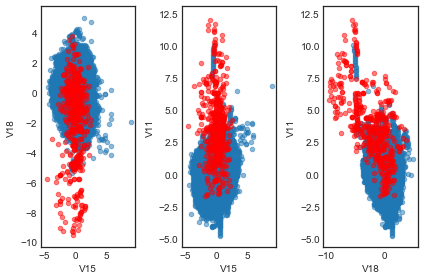

In [27]:
xfeat, yfeat, zfeat = feat_imp[0][0], feat_imp[1][0], feat_imp[2][0]

ax = plt.subplot(131)
X[y==0].plot.scatter(x=xfeat, y=yfeat, ax=ax, alpha=.5)
X[y==1].plot.scatter(x=xfeat, y=yfeat, ax=ax, alpha=.5, c='r')

ax = plt.subplot(132)
X[y==0].plot.scatter(x=xfeat, y=zfeat, ax=ax, alpha=.5)
X[y==1].plot.scatter(x=xfeat, y=zfeat, ax=ax, alpha=.5, c='r')

ax = plt.subplot(133)
X[y==0].plot.scatter(x=yfeat, y=zfeat, ax=ax, alpha=.5)
X[y==1].plot.scatter(x=yfeat, y=zfeat, ax=ax, alpha=.5, c='r')

plt.tight_layout()
plt.show()

plotting in 3D...

In [28]:
legit, fraud = df[df.Class==0].copy(), df[df.Class==1].copy()

In [29]:
idx = np.random.choice(range(len(legit)), 1000)

In [30]:
legit_sample = legit.loc[idx]

In [31]:
trace1 = go.Scatter3d(
    x=legit_sample.V11,
    y=legit_sample.V15,
    z=legit_sample.V18,
    mode='markers',
    name='legit',
    marker=dict(
        size=2,
        line=dict(
            color='rgba(0, 0, 217, 0.14)',
            width=0.1
        ),
        opacity=0.2
    )
)

trace2 = go.Scatter3d(
    x=fraud.V11,
    y=fraud.V15,
    z=fraud.V18,
    mode='markers',
    name='fraud',
    marker=dict(
        size=2,
        color='rgb(255, 127, 127)',
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=.1
        ),
        opacity=1.
    )
)
data = [trace1, trace2]

layout = go.Layout(
    title='Scatterplot between %s x %s x %s'%(xfeat, yfeat, zfeat),
    scene=dict(
        xaxis=dict(title='V11'),
        yaxis=dict(title='V15'),
        zaxis=dict(title='V18')
    ),
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=27
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')
# the interactive plot works better on the firefox

It's clear to see in the 3D plot the relation between fraud and legit. <br />
It seems that there is two cluster of legit transactions and the fraud transactions are spread away of them.
### Outlier removal
by looking at the following boxplot, we can see that there are a lot of outliers. 
this might be bias the model since the outliers might influence on the mean of the data, and the classifier might not perform very well.

In [32]:
feats = [feat[0] for feat in feat_imp[:5]]

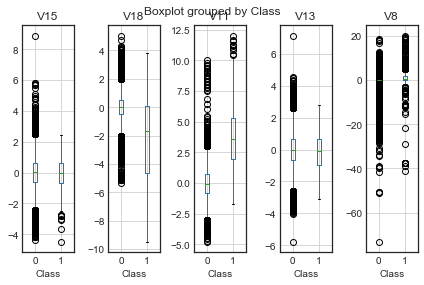

In [33]:
fig, axis = plt.subplots(1, 5)

for feat, ax in zip(feats, axis):
    df.boxplot(feat, 'Class', ax=ax)

plt.tight_layout()
plt.show()

In [34]:
legit = legit[feats]
fraud = fraud[feats]
# now i'll be removing the outliers
# since the fraudulent ones are scarce, I'll keep them
# removing outliers from legit sample
for idx, feat in enumerate(legit.columns):
    q75, q25 = np.percentile(legit[feat], [75 ,25])
    iqr_ = iqr(legit[feat])*1.5
    
    greater = np.array(legit[feat] <= q25 - iqr_, dtype=bool)
    legit.loc[greater, feat] = np.nan
    
    lower   = np.array(legit[feat] >= q75 + iqr_, dtype=bool)
    legit.loc[lower, feat] = np.nan
legit = pd.concat([legit, fraud], axis=0)
legit = pd.concat([legit, y], axis=1)
legit = legit.dropna()
# checking if there is a missing value
legit.isnull().sum()

V15      0
V18      0
V11      0
V13      0
V8       0
Class    0
dtype: int64

In [35]:
len(df) - len(legit)

36023

We only removed {{len(df) - len(legit)}} samples. It's a small quantity if we look at the legit's quantity. 

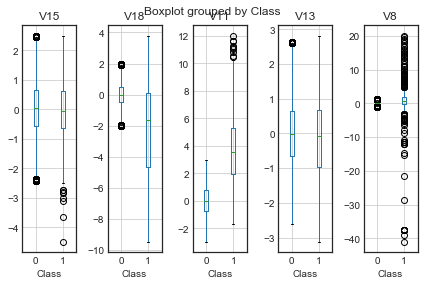

In [36]:
fig, axis = plt.subplots(1, 5)

for feat, ax in zip(feats, axis):
    legit.boxplot(feat, 'Class', ax=ax)

plt.tight_layout()
plt.show()

In [37]:
# separating the predictors and the labels
X, y = legit.iloc[:,:-1], legit.iloc[:,-1]

## Benchmark